
# Ландшафт функции потерь нейронных сетей: SAM и его модификации

##### *Фельдман Р. Г.,      2025*

---

## Введение

<div align="center">

<img src="https://www.researchgate.net/publication/371490019/figure/fig1/AS:11431281167028036@1686539720974/llustration-of-flat-and-sharp-minima-The-flat-minimum-is-robust-to-the-sharp-one-given.png" alt="olist" width="400"/>

&#x20;*Иллюстрация резких и плоских минимумов в одномерном срезе потерь. Плоский минимум имеет более широкую область низких потерь вокруг себя, в то время как потери острого минимума быстро увеличиваются при смещении весов, что указывает на высокую кривизну. Плоские минимумы более устойчивы к возмущениям и лучше обобщаются.*

</div>


Понимание **ландшафта потерь** нейронной сети - формы функции потерь в высокоразмерном весовом пространстве - имеет решающее значение для объяснения того, почему некоторые методы обучения обобщают лучше, чем другие. Современные глубокие сети сильно перепараметризованы и имеют множество локальных минимумов обучающих потерь, но не все минимумы одинаковы: одни приводят к хорошему обобщению, а другие - нет.  Исследования показали, что *резкость* или *плоскость* минимума сильно коррелирует с ошибкой обобщения. В частности, **острые минимумы** (где потери быстро растут в окрестности решения) плохо обобщаются, тогда как **плоские минимумы** (где потери остаются низкими в широкой окрестности), как правило, обобщаются хорошо. Это понимание, восходящее к Hochreiter & Schmidhuber (1997) и отмеченное Keskar *et al.* (2017) в контексте крупносерийного обучения, послужило мотивом для новых стратегий оптимизации, которые явно ищут более плоские минимумы. Например, мелкосерийный SGD неявно находит более плоские минимумы (из-за шума в градиентах) по сравнению с крупносерийным SGD, который часто попадает в более резкие минимумы.


---

*простая (не полная) интерпретация оптимизаторов*

Реализуем и сравним разные алгоритмы Sharpness-Aware Minimization на простой задаче линейной регрессии, включая как классический SAM, так и несколько вариантов с разреженностью, адаптивностью и учетом истории градиентов.

FriendlySAM sigma: 1 lambda: 0.5
Training SGD...
Epoch 1, Loss: 18.0149, R²: 0.2061
Epoch 2, Loss: 13.6960, R²: 0.4288
Epoch 3, Loss: 8.8517, R²: 0.5867
Epoch 4, Loss: 6.8932, R²: 0.6916
Epoch 5, Loss: 5.0609, R²: 0.7677
Epoch 6, Loss: 4.3967, R²: 0.8235
Epoch 7, Loss: 3.1202, R²: 0.8671
Epoch 8, Loss: 2.4173, R²: 0.8993
Epoch 9, Loss: 1.8574, R²: 0.9229
Epoch 10, Loss: 1.2905, R²: 0.9410
Epoch 11, Loss: 1.0441, R²: 0.9538
Epoch 12, Loss: 0.7769, R²: 0.9631
Epoch 13, Loss: 0.7114, R²: 0.9705
Epoch 14, Loss: 0.5162, R²: 0.9769
Epoch 15, Loss: 0.4128, R²: 0.9815
Epoch 16, Loss: 0.3652, R²: 0.9848
Epoch 17, Loss: 0.2606, R²: 0.9880
Epoch 18, Loss: 0.2175, R²: 0.9901
Epoch 19, Loss: 0.1873, R²: 0.9919
Epoch 20, Loss: 0.1610, R²: 0.9934
Training SAM...
Epoch 1, Loss: 20.1398, R²: 0.1619
Epoch 2, Loss: 12.8586, R²: 0.4366
Epoch 3, Loss: 8.5938, R²: 0.6039
Epoch 4, Loss: 6.1548, R²: 0.7165
Epoch 5, Loss: 6.1152, R²: 0.8004
Epoch 6, Loss: 2.9370, R²: 0.8734
Epoch 7, Loss: 2.1784, R²: 0.9110
Ep

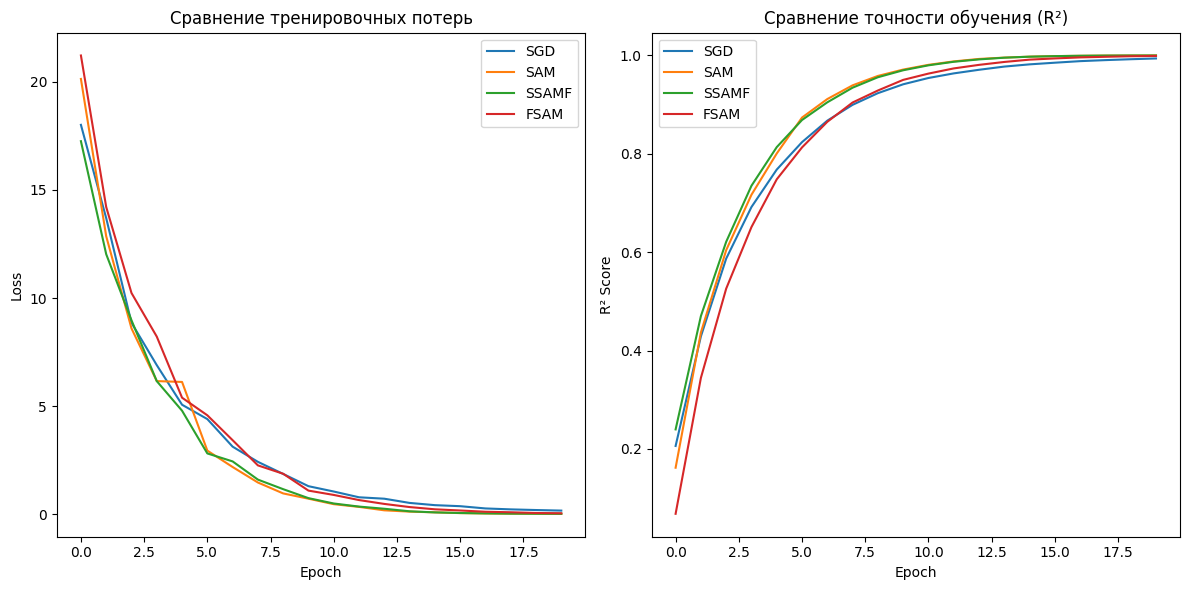

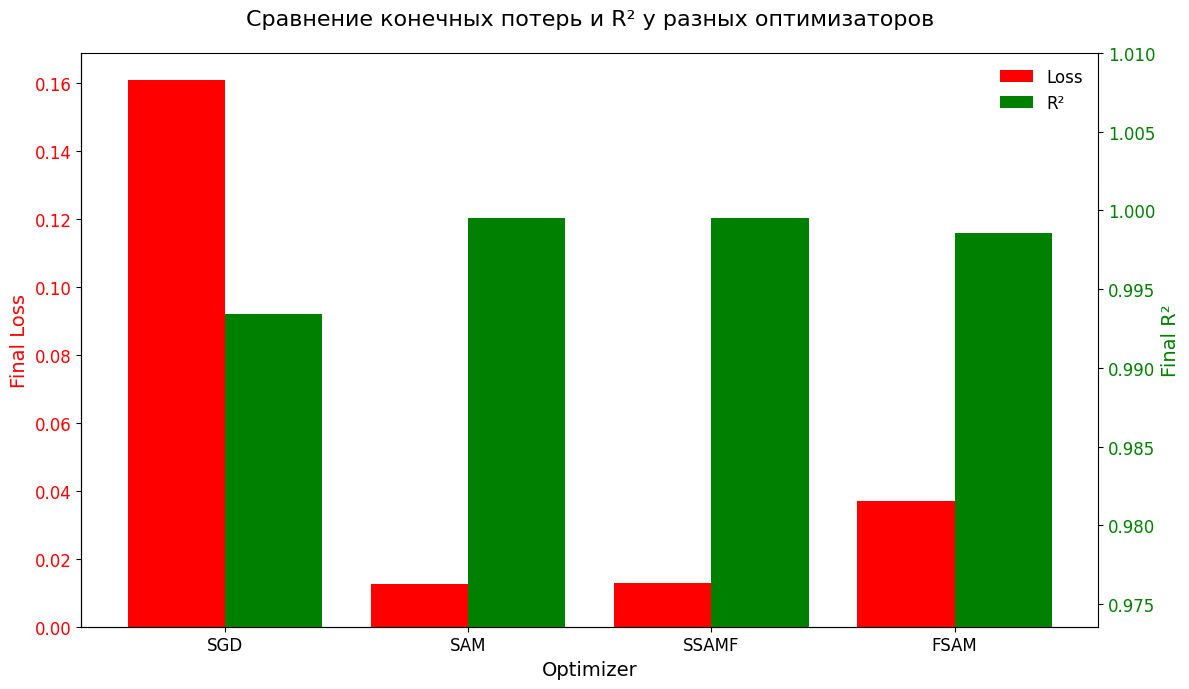

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import math
from sklearn.metrics import r2_score

class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho):
        assert isinstance(base_optimizer, torch.optim.Optimizer), "base_optimizer must be an `Optimizer`"
        self.base_optimizer = base_optimizer
        self.rho = rho
        super(SAM, self).__init__(params, dict(rho=rho))
        self.param_groups = self.base_optimizer.param_groups
        for group in self.param_groups:
            group["rho"] = rho

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-7)
            for p in group["params"]:
                if p.grad is None:
                    continue
                e_w = p.grad * scale
                if "e_w" not in self.state[p]:
                    self.state[p]["e_w"] = torch.zeros_like(p)
                self.state[p]["e_w"].copy_(e_w)
                p.add_(e_w)
        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                if "e_w" not in self.state[p]:
                    raise KeyError("first_step must be called before second_step")
                p.sub_(self.state[p]["e_w"])

        self.base_optimizer.step()
        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None, **kwargs):
        assert closure is not None, "SAM requires closure, which is not provided."
        self.first_step(True)
        with torch.enable_grad():
            closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device
        norm_list = [
            p.grad.norm(p=2).to(shared_device)
            for group in self.param_groups
            for p in group["params"]
            if p.grad is not None
        ]
        if not norm_list:
            return torch.tensor(0.0, device=shared_device)
        return torch.norm(torch.stack(norm_list), p=2)

class SSAMF(SAM):
    def __init__(self, params, base_optimizer, rho, sparsity, num_samples, update_freq):
        super(SSAMF, self).__init__(params, base_optimizer, rho)
        self.sparsity = sparsity
        self.num_samples = num_samples
        self.update_freq = update_freq
        self._initialized = False

    @torch.no_grad()
    def init_mask(self):
        for group in self.param_groups:
            for p in group["params"]:
                if "mask" not in self.state[p]:
                    self.state[p]["mask"] = torch.ones_like(p, requires_grad=False).to(p.device)
        self._initialized = True

    @torch.no_grad()
    def update_mask(self, epoch):
        if not self._initialized:
            raise RuntimeError("Masks are not initialized. Call `init_mask()` before training.")

        for group in self.param_groups:
            for p in group["params"]:
                if "mask" in self.state[p]:
                    mask = torch.rand_like(p) < self.sparsity
                    self.state[p]["mask"].copy_(mask.float())

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        if not self._initialized:
            raise RuntimeError("Masks are not initialized. Call `init_mask()` before training.")

        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-7)
            for p in group["params"]:
                if p.grad is None:
                    continue
                e_w = p.grad * scale
                e_w.data *= self.state[p]["mask"]
                if "e_w" not in self.state[p]:
                    self.state[p]["e_w"] = torch.zeros_like(p)
                self.state[p]["e_w"].copy_(e_w)
                p.add_(e_w)
        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None, epoch=None, batch_idx=None):
        assert closure is not None, "SAM requires closure, which is not provided."
        if not self._initialized:
            raise RuntimeError("Masks are not initialized. Call `init_mask()` before training.")

        self.first_step(True)

        if epoch is not None and batch_idx is not None:
            if epoch % self.update_freq == 0 and batch_idx == 0:
                self.update_mask(epoch)

        with torch.enable_grad():
            closure()
        self.second_step()

    @torch.no_grad()
    def mask_info(self):
        live_num = 0
        total_num = 0
        for group in self.param_groups:
            for p in group["params"]:
                if "mask" in self.state[p]:
                    live_num += self.state[p]["mask"].sum().item()
                    total_num += self.state[p]["mask"].numel()
        return float(live_num) / total_num if total_num > 0 else 0.0

class SSAMD(SAM):
    def __init__(self, params, base_optimizer, rho, sparsity, drop_rate, drop_strategy, growth_strategy, update_freq):
        super(SSAMD, self).__init__(params, base_optimizer, rho)
        self.sparsity = sparsity
        self.drop_rate = drop_rate
        self.drop_strategy = drop_strategy
        self.growth_strategy = growth_strategy
        self.update_freq = update_freq

    @torch.no_grad()
    def init_mask(self):
        random_scores = []
        for group in self.param_groups:
            for p in group["params"]:
                self.state[p]['score'] = torch.rand(size=p.shape).cpu().data
                random_scores.append(self.state[p]['score'])
        random_scores = torch.cat([torch.flatten(x) for x in random_scores])
        live_num = len(random_scores) - math.ceil(len(random_scores) *self.sparsity)
        _value, _index = torch.topk(random_scores, live_num)

        mask_list = torch.zeros_like(random_scores)
        mask_list.scatter_(0, _index, torch.ones_like(_value))
        start_index = 0
        for group in self.param_groups:
            for p in group['params']:
                self.state[p]['mask'] = mask_list[start_index: start_index + p.numel()].reshape(p.shape)
                self.state[p]['mask'] = self.state[p]['mask'].to(p)
                self.state[p]['mask'].require_grad = False
                del self.state[p]['score']
                start_index = start_index + p.numel()
                assert self.state[p]['mask'].max() <= 1.0 and self.state[p]['mask'].min() >= 0.0
        assert start_index == len(mask_list)

    @torch.no_grad()
    def DeathRate_Scheduler(self, epoch):
        dr = (self.drop_rate) * (1 + math.cos(math.pi * (float(epoch - self.T_start) / (self.T_end - self.T_start)))) / 2
        return dr

    @torch.no_grad()
    def update_mask(self, epoch, **kwargs):
        death_scores = []
        growth_scores =[]
        for group in self.param_groups:
            for p in group['params']:
                death_score = self.get_score(p, self.drop_strategy)
                death_scores.append((death_score + 1e-7) * self.state[p]['mask'].data)

                growth_score = self.get_score(p, self.growth_strategy)
                growth_scores.append((growth_score + 1e-7) * (1 - self.state[p]['mask'].data))

        death_scores = torch.cat([torch.flatten(x) for x in death_scores])
        death_rate = self.DeathRate_Scheduler(epoch=epoch)
        death_num = int(min((len(death_scores) - len(death_scores) * self.sparsity)* death_rate, len(death_scores) * self.sparsity))
        d_value, d_index = torch.topk(death_scores, int((len(death_scores) - len(death_scores) * self.sparsity) * (1 - death_rate)))

        death_mask_list = torch.zeros_like(death_scores)
        death_mask_list.scatter_(0, d_index, torch.ones_like(d_value))

        growth_scores = torch.cat([torch.flatten(x) for x in growth_scores])
        growth_num = death_num
        g_value, g_index = torch.topk(growth_scores, growth_num)

        growth_mask_list = torch.zeros_like(growth_scores)
        growth_mask_list.scatter_(0, g_index, torch.ones_like(g_value))

        start_index = 0
        for group in self.param_groups:
            for p in group['params']:
                death_mask = death_mask_list[start_index: start_index + p.numel()].reshape(p.shape)
                growth_mask = growth_mask_list[start_index: start_index + p.numel()].reshape(p.shape)

                self.state[p]['mask'] = death_mask + growth_mask
                self.state[p]['mask'] = self.state[p]['mask'].to(p)
                self.state[p]['mask'].require_grad = False
                start_index = start_index + p.numel()
                assert self.state[p]['mask'].max() <= 1.0 and self.state[p]['mask'].min() >= 0.0


        assert start_index == len(death_mask_list)

    def get_score(self, p, score_model=None):
        if score_model == 'weight':
            return torch.abs(p.clone()).cpu().data
        elif score_model == 'gradient':
            return torch.abs(p.grad.clone()).cpu().data
        elif score_model == 'random':
            return torch.rand(size=p.shape).cpu().data
        else:
            raise KeyError

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-7)
            for p in group["params"]:
                if p.grad is None:
                    continue
                e_w = p.grad * scale
                e_w.data = e_w.data * self.state[p]['mask']
                if "e_w" not in self.state[p]:
                    self.state[p]["e_w"] = torch.zeros_like(p)
                self.state[p]["e_w"].copy_(e_w)
                p.add_(e_w)
        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None, **kwargs):
        assert closure is not None, "SAM requires closure, which is not provided."

        self.first_step(True)
        self.zero_grad()
        with torch.enable_grad():
            closure()
        self.second_step()

    @torch.no_grad()
    def mask_info(self):
        live_num = 0
        total_num = 0
        for group in self.param_groups:
            for p in group['params']:
                live_num += self.state[p]['mask'].sum().item()
                total_num += self.state[p]['mask'].numel()
        return float(live_num) / total_num

class FriendlySAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho, sigma=1, lmbda=0.5, adaptive=False):
        defaults = dict(rho=rho, adaptive=adaptive)
        super(FriendlySAM, self).__init__(params, defaults)
        self.base_optimizer = base_optimizer
        self.sigma = sigma
        self.lmbda = lmbda
        print ('FriendlySAM sigma:', self.sigma, 'lambda:', self.lmbda)

    @torch.no_grad()
    def first_step(self, zero_grad=False):

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                grad = p.grad.clone()
                if not "momentum" in self.state[p]:
                    self.state[p]["momentum"] = grad
                else:
                    p.grad -= self.state[p]["momentum"] * self.sigma
                    self.state[p]["momentum"] = self.state[p]["momentum"] * self.lmbda + grad * (1 - self.lmbda)

        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]

        self.base_optimizer.step()

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device
        norm_list = [
            p.grad.norm(p=2).to(shared_device)
            for group in self.param_groups
            for p in group["params"]
            if p.grad is not None
        ]
        if not norm_list:
            return torch.tensor(0.0, device=shared_device)
        return torch.norm(torch.stack(norm_list), p=2)
class ImbSAM(SAM):
    def __init__(self, model, base_optimizer, rho=0.05):
        super(ImbSAM, self).__init__(model.parameters(), base_optimizer, rho)
        self.model = model
        self.optimizer = base_optimizer

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        for n, p in self.model.named_parameters():
            if p.grad is None:
                continue
            grad_normal = self.state[p].get("grad_normal")
            if grad_normal is None:
                self.state[p]["grad_normal"] = torch.clone(p.grad).detach()
            else:
                self.state[p]["grad_normal"].copy_(p.grad)
        if zero_grad:
            self.optimizer.zero_grad()

    @torch.no_grad()
    def second_step(self):
        grads = []
        for n, p in self.model.named_parameters():
            if p.grad is None:
                continue
            grads.append(torch.norm(p.grad, p=2))

        grad_norm = torch.norm(torch.stack(grads), p=2) + 1.e-7

        for n, p in self.model.named_parameters():
            if p.grad is None:
                continue

            eps = self.state[p].get("eps")
            if eps is None:
                self.state[p]["eps"] = torch.clone(p.grad).detach()
            else:
                self.state[p]["eps"].copy_(p.grad)

            self.state[p]["eps"].mul_(self.rho / grad_norm)
            self.state[p]["eps"].clamp_(-0.1, 0.1)
            p.add_(self.state[p]["eps"])

        self.optimizer.zero_grad()

    @torch.no_grad()
    def third_step(self):
        for n, p in self.model.named_parameters():
            if p.grad is None:
                continue
            p.sub_(self.state[p]["eps"])

            if "grad_normal" not in self.state[p]:
                raise KeyError("grad_normal missing from state")

            p.grad.add_(self.state[p]["grad_normal"])

        self.optimizer.step()
        self.optimizer.zero_grad()


def train_with_accuracy(model, optimizer, criterion, dataloader, epochs):
    losses = []
    accuracies = []

    for epoch in range(epochs):
        epoch_loss = 0
        y_true_all = []
        y_pred_all = []

        for x_batch, y_batch in dataloader:
            def closure():
                optimizer.zero_grad()
                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                return loss

            loss = closure()
            optimizer.step(closure)
            epoch_loss += loss.item()

            y_pred = model(x_batch).detach().numpy()
            y_true = y_batch.numpy()
            y_pred_all.extend(y_pred)
            y_true_all.extend(y_true)

        losses.append(epoch_loss / len(dataloader))
        r2 = r2_score(y_true_all, y_pred_all)
        accuracies.append(r2)

        print(f"Epoch {epoch + 1}, Loss: {losses[-1]:.4f}, R²: {r2:.4f}")

    return losses, accuracies

torch.manual_seed(42)
input_size = 10
output_size = 1
num_samples = 100
x = torch.randn(num_samples, input_size)
true_y =x @ torch.randn(input_size, output_size)
y = true_y + torch.randn(num_samples, output_size) * 0.1
dataset = torch.utils.data.TensorDataset(x, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
epochs = 20

models = {
    "SGD": LinearRegression(input_size, output_size),
    "SAM": LinearRegression(input_size, output_size),
    "SSAMF": LinearRegression(input_size, output_size),
    "FSAM": LinearRegression(input_size, output_size),
}

optimizers = {
    "SGD": optim.SGD(models["SGD"].parameters(), lr=0.01),
    "SAM": SAM(models["SAM"].parameters(), base_optimizer=optim.SGD(models["SAM"].parameters(), lr=0.01), rho=0.5),
    "SSAMF": SSAMF(models["SSAMF"].parameters(), base_optimizer=optim.SGD(models["SSAMF"].parameters(), lr=0.01), rho=0.5, sparsity=0.1, num_samples=5, update_freq=10),
    "FSAM": FriendlySAM(models["FSAM"].parameters(), base_optimizer=optim.SGD(models["FSAM"].parameters(), lr=0.01), rho=0.5),
}
optimizers['SSAMF'].init_mask()

criterion = nn.MSELoss()

all_losses = {}
all_accuracies = {}

for name, model in models.items():
    print(f"Training {name}...")
    losses, accuracies = train_with_accuracy(model, optimizers[name], criterion, dataloader, epochs)
    all_losses[name] = losses
    all_accuracies[name] = accuracies

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for name, losses in all_losses.items():
    plt.plot(losses, label=name)
plt.title("Сравнение тренировочных потерь")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
for name, accuracies in all_accuracies.items():
    plt.plot(accuracies, label=name)
plt.title("Сравнение точности обучения (R²)")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.legend()

plt.tight_layout()
plt.show()
print()
optimizers = ['SGD', 'SAM', 'SSAMF', 'FSAM']
final_losses = [all_losses['SGD'][-1],
                all_losses['SAM'][-1],
                all_losses['SSAMF'][-1],
                all_losses['FSAM'][-1]]
final_r2 = [all_accuracies['SGD'][-1],
            all_accuracies['SAM'][-1],
            all_accuracies['SSAMF'][-1],
            all_accuracies['FSAM'][-1]]

x = np.arange(len(optimizers))
width = 0.4

fig, ax1 = plt.subplots(figsize=(12, 7))

bars1 = ax1.bar(x - width/2, final_losses, width,
                label='Loss', color='red')
ax1.set_xlabel('Optimizer', fontsize=14)
ax1.set_ylabel('Final Loss', fontsize=14, color='red')
ax1.tick_params(axis='y', labelcolor='red', labelsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(optimizers, fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, final_r2, width,
                label='R²', color='green')
ax2.set_ylabel('Final R²', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green', labelsize=12)
ax2.set_ylim(min(final_r2) * 0.98, 1.01)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,
           loc='upper right', frameon=False, fontsize=12)

plt.title('Сравнение конечных потерь и R² у разных оптимизаторов', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


---

Продвинутые реализации, соотвествующие оригинально предложенным алгоритмам

In [24]:
import math
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

def smooth_crossentropy(pred, gold, smoothing=0.1):
    """
    Вычисляет кросс-энтропию с label smoothing.
    pred: тензор логитов формы [batch, classes]
    gold: тензор целевых меток [batch]
    smoothing: степень размытия меток
    """
    n_class = pred.size(1)
    if n_class <= 1:
        return F.mse_loss(pred, gold.unsqueeze(1).float())

    # создаём one-hot с небольшим заполнением для всех классов
    one_hot = torch.full_like(pred, fill_value=smoothing / (n_class - 1))
    one_hot.scatter_(1, gold.unsqueeze(1), 1.0 - smoothing)
    log_prob = F.log_softmax(pred, dim=1)
    return F.kl_div(log_prob, one_hot, reduction='none').sum(-1)

# Классы

## 1. (Adaptive) Sharpness-Aware Minimization (SAM)

In [51]:
import torch
from torch.optim import Optimizer

class SAM(Optimizer):
    """
    Sharpness-Aware Minimization (SAM) optimizer.
    """

    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        """
        params: параметры модели
        base_optimizer: класс базового оптимизатора (например, torch.optim.SGD)
        rho: радиус шага в пространстве весов
        adaptive: флаг адаптивного масштабирования (ASAM)
        **kwargs: дополнительные аргументы для базового оптимизатора
        """
        assert rho >= 0.0, f"Неверное значение rho: {rho}"
        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super().__init__(params, defaults)

        # Инициализируем базовый оптимизатор
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        # Синхронизируем группы параметров и их дефолты
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        """
        Первый «восходящий» шаг: поднимаемся по градиенту на расстояние rho.
        Если adaptive=True, коэффициент пропорционален абсолютному значению весов.
        """
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)
            for p in group["params"]:
                if p.grad is None:
                    continue
                # Сохраняем старые веса для восстановления
                self.state[p]["old_p"] = p.data.clone()
                coef = torch.abs(p) if group["adaptive"] else 1.0
                e_w = coef * p.grad * scale.to(p.dtype)
                p.add_(e_w)  # w ← w + e(w)

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        """
        Второй «нисходящий» шаг: возвращаем оригинальные веса и делаем шаг
        базовым оптимизатором с учётом новых градиентов.
        """
        # Восстанавливаем исходные веса
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                p.data = self.state[p]["old_p"]

        # Шаг базового оптимизатора
        self.base_optimizer.step()

        if zero_grad:
            self.zero_grad()

    def step(self, closure=None):
        """
        Полный шаг SAM: вычисляем градиенты, делаем ascent, пересчёт градиентов и descent.
        closure: функция, выполняющая полный проход (forward + backward).
        """
        assert closure is not None, "Для SAM требуется передать closure"
        # Включаем градиенты внутри closure
        closure = torch.enable_grad()(closure)

        # 1) Вычисляем начальную потерю и градиенты
        loss = closure()
        # 2) Атакующий шаг (ascent)
        self.first_step(zero_grad=True)
        # 3) Пересчитываем градиенты в точке w + e(w)
        loss = closure()
        # 4) Нисходящий шаг (descent)
        self.second_step()
        return loss

    def _grad_norm(self):
        """
        Подсчёт нормы градиента для всех параметров.
        При adaptive=True используем взвешенный градиент.
        """
        device = self.param_groups[0]["params"][0].device
        norms = []
        for group in self.param_groups:
            coef = None
            for p in group["params"]:
                if p.grad is None:
                    continue
                # Выбор коэффициента для adaptive SAM
                coef = torch.abs(p) if group["adaptive"] else 1.0
                norms.append((coef * p.grad).norm(p=2).to(device))
        # Общая L2-норма
        return torch.norm(torch.stack(norms), p=2)

    def load_state_dict(self, state_dict):
        """
        Загружает состояние оптимизатора и синхронизирует param_groups у базового оптимизатора.
        """
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups


## 2. FriendlySAM

In [52]:
import torch
from torch.optim import Optimizer

class FriendlySAM(Optimizer):
    """
    Sharpness-Aware Minimization с дружелюбным направлением градиента.
    Добавляет EMA и корректирует направление шага.
    """

    def __init__(
        self,
        params,
        base_optimizer,
        rho: float = 0.05,
        sigma: float = 1.0,
        lmbda: float = 0.9,
        adaptive: bool = False,
        **kwargs
    ):
        """
        params: параметры модели
        base_optimizer: класс оптимизатора (torch.optim.SGD и т.п.)
        rho: радиус perturbation для SAM
        sigma: коэффициент весового вычитания EMA из градиента
        lmbda: коэффициент экспоненциального сглаживания для EMA
        adaptive: флаг адаптивного SAM
        **kwargs: lr, momentum, weight_decay и др. для base_optimizer
        """
        assert rho >= 0.0, f"rho должно быть >= 0, получено: {rho}"
        # Инициализируем Optimizer
        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super().__init__(params, defaults)

        # Базовый оптимизатор и его параметры
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

        # Параметры FriendlySAM
        self.sigma = sigma
        self.lmbda = lmbda

    @torch.no_grad()
    def first_step(self, zero_grad: bool = False):
        """
        Первый шаг SAM: корректируем градиент через EMA, затем ascent-перемещение.
        """
        # Проходим по всем группам параметров
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                g = p.grad.detach()
                state = self.state[p]
                # Инициализация EMA m_t
                if 'momentum' not in state:
                    state['momentum'] = torch.zeros_like(p)
                state['momentum'].mul_(self.lmbda).add_(g, alpha=1 - self.lmbda)
                # Вычисляем дружелюбное направление d_t = g - sigma * m_t
                d = g - self.sigma * state['momentum']
                p.grad = d

        # Стандартный ascent SAM
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group['rho'] / (grad_norm + 1e-12)
            for p in group['params']:
                if p.grad is None:
                    continue
                # Сохраняем старые веса
                self.state[p]['old_p'] = p.data.clone()
                coeff = torch.abs(p) if group['adaptive'] else 1.0
                e_w = coeff * p.grad * scale.to(p.dtype)
                p.add_(e_w)
        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad: bool = False):
        """
        Второй шаг SAM: возвращаем веса и вызываем базовый optimizer.step().
        """
        # Восстанавливаем исходные веса перед descent
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                p.data = self.state[p]['old_p']
        # Шаг базового оптимизатора
        self.base_optimizer.step()
        if zero_grad:
            self.zero_grad()

    def step(self, closure=None):
        """
        Полный шаг SAM: ascent и descent через две фазы closure().
        closure: функция, выполняющая forward+backward.
        """
        assert closure is not None, "Для SAM требуется closure"
        closure = torch.enable_grad()(closure)
        # Первая фаза: вычисляем градиенты
        loss = closure()
        # Ascent с дружелюбным направлением
        self.first_step(zero_grad=True)
        # Вторая фаза: переоценка градиентов
        loss = closure()
        # Descent
        self.second_step()
        return loss

    @torch.no_grad()
    def _grad_norm(self) -> torch.Tensor:
        """
        Считает L2-норму градиента по всем параметрам,
        с учётом adaptive SAM, если включён.
        """
        device = self.param_groups[0]['params'][0].device
        norms = []

        for group in self.param_groups:
            adaptive = group.get('adaptive', False)
            for p in group['params']:
                if p.grad is None:
                    continue
                # compute coefficient per-parameter
                coeff = torch.abs(p) if adaptive else 1.0
                norms.append((coeff * p.grad).norm(p=2).to(device))

        # stack all and take overall L2-norm
        return torch.norm(torch.stack(norms), p=2)

    def load_state_dict(self, state_dict):
        """
        Загружает состояние optimizer и синхронизирует param_groups базового optimizer.
        """
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups


## 3. Sparse SAM (SSAM)

### 3.1. SSAM-Fisher

In [53]:
import torch
from torch.optim import Optimizer

class SSAMF(SAM):
    """
    Sparse Sharpness-Aware Minimization с фильтрацией по Фишеру.
    Наследует SAM, добавляя регулярное обновление разрежающей маски.
    """

    def __init__(
        self,
        params,
        base_optimizer,
        rho: float,
        sparsity: float,
        num_samples: int,
        update_freq: int,
        criterion,
        **kwargs
    ):
        """
        params: параметры модели
        base_optimizer: класс базового оптимизатора (torch.optim.SGD и т.п.)
        rho: радиус SAM
        sparsity: доля «обнуляемых» направлений (0–1)
        num_samples: число точек для оценки Фишера
        update_freq: частота (в эпохах) обновления маски
        criterion: функция потерь для оценки Фишера
        **kwargs: lr, momentum, weight_decay и остальные для base_optimizer
        """
        super().__init__(params, base_optimizer, rho, **kwargs)

        assert 0.0 <= sparsity <= 1.0, f"sparsity ∈ [0,1], получено: {sparsity}"
        assert num_samples >= 1, f"num_samples ≥ 1, получено: {num_samples}"
        assert update_freq >= 1, f"update_freq ≥ 1, получено: {update_freq}"

        self.sparsity = sparsity
        self.num_samples = num_samples
        self.update_freq = update_freq
        self.criterion = criterion

        # Обогащаем группы параметров метаданными
        for g in self.param_groups:
            g.update(dict(
                sparsity=sparsity,
                num_samples=num_samples,
                update_freq=update_freq
            ))

        self.init_mask()

    @torch.no_grad()
    def init_mask(self):
        """
        Инициализирует нулевую маску для каждого параметра.
        """
        for g in self.param_groups:
            for p in g['params']:
                self.state[p]['mask'] = torch.zeros_like(p)

    @torch.no_grad()
    def update_mask(self, model, train_data):
        """
        Оценивает значимость параметров по Фишеру и обновляет маску.
        """
        fisher = {id(p): torch.zeros_like(p) for g in self.param_groups for p in g['params']}
        was_train = model.training
        model.eval()

        loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
        with torch.enable_grad():
            for i, (x, y) in enumerate(loader):
                if i >= self.num_samples:
                    break
                x, y = x.cuda(), y.cuda()
                out = model(x)
                loss = self.criterion(out, y).mean()
                loss.backward()
                for g in self.param_groups:
                    for p in g['params']:
                        fisher[id(p)] += p.grad.square()
                model.zero_grad()
        if was_train:
            model.train()

        all_vals = torch.cat([v.flatten() for v in fisher.values()])
        k = int(len(all_vals) * (1 - self.sparsity))
        _, idx = torch.topk(all_vals, k)

        mask_flat = torch.zeros_like(all_vals)
        mask_flat[idx] = 1.0

        offset = 0
        for g in self.param_groups:
            for p in g['params']:
                n = p.numel()
                self.state[p]['mask'] = mask_flat[offset:offset+n].view_as(p).to(p.device)
                offset += n

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        """
        Ascent-шаг SAM с применением текущей маски.
        """
        grad_norm = self._grad_norm()
        for g in self.param_groups:
            scale = g['rho'] / (grad_norm + 1e-12)
            for p in g['params']:
                if p.grad is None:
                    continue
                self.state[p]['old_p'] = p.data.clone()
                e_w = p.grad * scale
                e_w.mul_(self.state[p]['mask'])
                p.add_(e_w)
        if zero_grad:
            self.zero_grad()

    def step(self, closure=None, model=None, train_data=None, epoch=None, batch_idx=None, logger=None):
        """
        Выполняет SAM-шаг и обновляет маску при необходимости.
        """
        assert closure is not None, "Для SSAMF нужен closure"
        assert model is not None and train_data is not None
        assert epoch is not None and batch_idx is not None and logger is not None

        # Ascend + Descent через SAM
        loss = super().step(closure)

        # Обновление маски в начале эпохи
        if (epoch % self.update_freq == 0) and (batch_idx == 0):
            logger.log("Обновление маски SSAMF")
            self.update_mask(model, train_data)
            logger.log(f"Доля живых весов: {self.mask_info():.4f}")

        return loss

    @torch.no_grad()
    def mask_info(self) -> float:
        """
        Доля активных элементов маски.
        """
        live = total = 0
        for g in self.param_groups:
            for p in g['params']:
                m = self.state[p]['mask']
                live += m.sum().item()
                total += m.numel()
        return live / total

### 3.2. SSAM-Dynamic

In [5]:
import math
import torch
from torch.optim import Optimizer

class SSAMD(SAM):
    """
    Sparse SAM с динамическим выпадением и ростом (SSAMD).
    Расширяет SAM добавлением стратегий дропаута и нового роста параметров.
    """

    def __init__(
        self,
        params,
        base_optimizer,
        rho: float,
        sparsity: float,
        drop_rate: float,
        drop_strategy: str,
        growth_strategy: str,
        update_freq: int,
        T_start: int,
        T_end: int,
        **kwargs
    ) -> None:
        """
        params: параметры модели
        base_optimizer: класс или экземпляр Optimizer
        rho: радиус SAM
        sparsity: доля обнуляемых параметров
        drop_rate: максимальная доля дропа за эпоху
        drop_strategy: критерий расчёта "скорости" для дропа ('weight', 'gradient', 'random')
        growth_strategy: критерий для роста ('weight', 'gradient', 'random')
        update_freq: частота (в эпохах) обновления маски
        T_start, T_end: начало и конец цикла изменения drop_rate (эпохи)
        **kwargs: другие аргументы для базового оптимизатора
        """
        # Проверка входных аргументов
        import torch.optim as optim
        assert (
            isinstance(base_optimizer, optim.Optimizer)
            or (isinstance(base_optimizer, type)
                and issubclass(base_optimizer, optim.Optimizer))
        ), "base_optimizer должен быть Optimizer или его класс"

        super().__init__(params, base_optimizer, rho, **kwargs)
        assert rho >= 0.0, f"rho >= 0, получено {rho}"
        assert 0.0 <= sparsity <= 1.0, f"sparsity ∈ [0,1], получено {sparsity}"
        assert 0.0 <= drop_rate <= 1.0, f"drop_rate ∈ [0,1], получено {drop_rate}"
        assert update_freq >= 1, f"update_freq >=1, получено {update_freq}"

        # Параметры SSAMD
        self.sparsity = sparsity
        self.drop_rate = drop_rate
        self.drop_strategy = drop_strategy
        self.growth_strategy = growth_strategy
        self.update_freq = update_freq
        self.T_start = T_start
        self.T_end = T_end

        # Добавляем поля в param_groups
        for group in self.param_groups:
            group.update({
                "sparsity": sparsity,
                "drop_rate": drop_rate,
                "drop_strategy": drop_strategy,
                "growth_strategy": growth_strategy,
                "update_freq": update_freq,
                "T_end": T_end,
                "T_start": T_start
            })

        self.init_mask()

    @torch.no_grad()
    def init_mask(self):
        """
        Инциализируем маску случайным образом, сохраняя top-(1-sparsity) параметров.
        """
        scores = []
        # Генерируем случайные скоры
        for group in self.param_groups:
            for p in group['params']:
                score = torch.rand_like(p)
                self.state[p]['score'] = score.cpu()
                scores.append(score.flatten())

        all_scores = torch.cat(scores)
        keep = int(len(all_scores) * (1 - self.sparsity))
        top_vals, top_idx = torch.topk(all_scores, keep)
        mask_flat = torch.zeros_like(all_scores)
        mask_flat.scatter_(0, top_idx, 1.0)

        # Распределяем обратно по параметрам
        offset = 0
        for group in self.param_groups:
            for p in group['params']:
                numel = p.numel()
                m = mask_flat[offset:offset+numel].view_as(p)
                self.state[p]['mask'] = m.to(p)
                del self.state[p]['score']
                offset += numel

    @torch.no_grad()
    def DeathRate_Scheduler(self, epoch: int) -> float:
        """
        Косинусный планировщик для динамики drop_rate от T_start до T_end.
        """
        progress = (epoch - self.T_start) / (self.T_end - self.T_start)
        cos_val = (1 + math.cos(math.pi * progress)) / 2
        return self.drop_rate * cos_val

    @torch.no_grad()
    def update_mask(self, epoch: int, **kwargs):
        """
        Обновляем маску: вычисляем death и growth скоры, отбираем параметры методом TopK.
        """
        death_list, growth_list = [], []
        # Считаем скоры
        for group in self.param_groups:
            for p in group['params']:
                death_score = self.get_score(p, self.drop_strategy) * self.state[p]['mask']
                growth_score = self.get_score(p, self.growth_strategy) * (1 - self.state[p]['mask'])
                death_list.append(death_score.flatten())
                growth_list.append(growth_score.flatten())

        death_scores = torch.cat(death_list)
        rate = self.DeathRate_Scheduler(epoch)
        drop_k = int((len(death_scores) - len(death_scores)*self.sparsity) * rate)
        keep_k = int(len(death_scores)*(1-self.sparsity) - drop_k)
        _, death_idx = torch.topk(death_scores, keep_k)

        growth_scores = torch.cat(growth_list)
        _, growth_idx = torch.topk(growth_scores, drop_k)

        total_len = death_scores.numel()
        new_mask = torch.zeros(total_len, device=death_scores.device)
        new_mask.scatter_(0, death_idx, 1.0)
        new_mask.scatter_(0, growth_idx, 1.0)

        # Применяем новую маску к параметрам
        offset = 0
        for group in self.param_groups:
            for p in group['params']:
                numel = p.numel()
                m = new_mask[offset:offset+numel].view_as(p)
                self.state[p]['mask'] = m.to(p)
                offset += numel

    def get_score(self, p: torch.Tensor, mode: str) -> torch.Tensor:
        device = p.device
        if mode == 'weight':
            return p.abs().detach().to(device)
        elif mode == 'gradient':
            return p.grad.abs().detach().to(device)
        elif mode == 'random':
            return torch.rand_like(p).to(device)
        else:
            raise KeyError(f"Unknown mode: {mode}")

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        """
        Ascent-шаг SAM с учётом маски: добавляем perturbation только для активных параметров.
        """
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group['rho'] / (grad_norm + 1e-7)
            for p in group['params']:
                if p.grad is None:
                    continue
                self.state[p]['old_p'] = p.data.clone()
                e_w = p.grad * scale
                e_w.mul_(self.state[p]['mask'])
                p.add_(e_w)
                self.state[p]['e_w'] = e_w
        if zero_grad:
            self.zero_grad()

    def step(self, closure=None, epoch=None, batch_idx=None, logger=None, **kwargs):
        """
        Полный шаг: SAM ascent/descent и обновление маски по расписанию.
        """
        assert closure is not None, "SAM требует closure"
        closure = torch.enable_grad()(closure)

        loss1 = closure()
        self.first_step()

        # Обновляем маску в начале эпохи при batch_idx=0
        if (epoch % self.update_freq == 0) and (batch_idx == 0):
            logger.log("Обновление маски SSAMD")
            self.update_mask(epoch)
            logger.log(f"Доля живых весов: {self.mask_info():.4f}")

        self.zero_grad()
        loss2 = closure()
        self.second_step()
        return loss2

    @torch.no_grad()
    def mask_info(self) -> float:
        """
        Возвращает долю активных (1) элементов маски.
        """
        live = total = 0
        for group in self.param_groups:
            for p in group['params']:
                m = self.state[p]['mask']
                live += m.sum().item()
                total += m.numel()
        return live / total


---

In [20]:
# standard CIFAR-100 normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                         download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=4)


In [21]:
# ResNet-18
def make_model():
    model = torchvision.models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 100)
    return model.cuda()

In [22]:
import torch.optim as optim

names = ['SAM', 'FriendlySAM', 'SSAMF', 'SSAMD']
metrics = {
    'batch_loss': {n: [] for n in names},
    'epoch_acc': {n: [] for n in names},
}
model_snapshots = {n: [] for n in names}
models = {n: make_model() for n in names}
optimizers = {
    'SAM': SAM(models['SAM'].parameters(),
               base_optimizer=optim.SGD,
               lr=0.1, momentum=0.9, weight_decay=5e-4, rho=0.05),

    'FriendlySAM': FriendlySAM(models['FriendlySAM'].parameters(),
                               base_optimizer=optim.SGD,
                               lr=0.1, momentum=0.9, weight_decay=5e-4,
                               rho=0.05, sigma=0.9, lmbda=0.9),

    'SSAMF': SSAMF(models['SSAMF'].parameters(),
                  base_optimizer=optim.SGD,
                  rho=0.05,
                  sparsity=0.5,
                  num_samples=100,
                  update_freq=1,
                  lr=0.1,
                  momentum=0.9,
                  weight_decay=5e-4,
                  criterion=smooth_crossentropy),

    'SSAMD': SSAMD(models['SSAMD'].parameters(),
                  base_optimizer=optim.SGD,
                  rho=0.05,
                  sparsity=0.5,
                  drop_rate=0.2,
                  drop_strategy='gradient',
                  growth_strategy='random',
                  update_freq=1,
                  T_start=0,
                  T_end=200,
                  lr=0.1,
                  momentum=0.9,
                  weight_decay=5e-4),
}


In [23]:
# new hyper params example

optimizers = {
    'SAM': SAM(
        models['SAM'].parameters(),
        base_optimizer=optim.Adam,
        lr=0.005,
        betas=(0.9, 0.999),
        weight_decay=1e-3,
        rho=0.2,
        adaptive=True
    ),

    'FriendlySAM': FriendlySAM(
        models['FriendlySAM'].parameters(),
        base_optimizer=optim.RMSprop,
        lr=0.02,
        alpha=0.99,
        weight_decay=0,
        rho=0.1,
        sigma=0.3,
        lmbda=0.6,
        adaptive=True
    ),

    'SSAMF': SSAMF(
        models['SSAMF'].parameters(),
        base_optimizer=optim.SGD,
        lr=0.2,
        momentum=0.0,
        weight_decay=1e-5,
        rho=0.1,
        sparsity=0.8,
        num_samples=50,
        update_freq=5,
        criterion=smooth_crossentropy
    ),

    'SSAMD': SSAMD(
        models['SSAMD'].parameters(),
        base_optimizer=optim.AdamW,
        lr=0.001,
        betas=(0.95, 0.999),
        weight_decay=5e-4,
        rho=0.15,
        sparsity=0.2,
        drop_rate=0.5,
        drop_strategy='weight',
        growth_strategy='gradient',
        update_freq=2,
        T_start=10,
        T_end=100
    ),
}


In [15]:
criterion = smooth_crossentropy

class SimpleLogger:
    def log(self, msg): print(msg)
logger = SimpleLogger()

num_epochs = 20

In [24]:
import copy

for epoch in range(1, num_epochs+1):
    for n in names:
        models[n].train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        for n in names:
            opt = optimizers[n]
            mdl = models[n]
            def closure():
                opt.zero_grad()
                out = mdl(inputs)
                loss = criterion(out, targets).mean()
                loss.backward()
                return loss
            if n == 'SSAMF':
                loss = opt.step(closure=closure, model=mdl, epoch=epoch, batch_idx=batch_idx, train_data=trainset, logger=logger)
            elif n == 'SSAMD':
                loss = opt.step(closure=closure, epoch=epoch, batch_idx=batch_idx, logger=logger)
            else:
                loss = opt.step(closure)
            metrics['batch_loss'][n].append(loss.item())
            if batch_idx % 100 == 0:
                model_snapshots[n].append(copy.deepcopy(mdl.state_dict()))
            if batch_idx % 100 == 0:
                print(f"[{n}] Batch {batch_idx} Loss {loss.item():.4f}")

    for n in names:
        models[n].eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.cuda(), targets.cuda()
                preds = models[n](inputs).argmax(dim=1)
                correct += (preds == targets).sum().item()
                total += targets.size(0)
        acc = correct / total
        metrics['epoch_acc'][n].append(acc)
        print(f"[{n}] Epoch {epoch} Overall Acc: {acc*100:.2f}%")

print("Training complete.")

[SAM] Batch 0 Loss 4.5168
[FriendlySAM] Batch 0 Loss 4.5289
[SSAMF] Batch 0 Loss 4.1419
[SSAMD] Batch 0 Loss 4.5204
[SAM] Batch 100 Loss 3.5944
[FriendlySAM] Batch 100 Loss 3.8097
[SSAMF] Batch 100 Loss 3.4146
[SSAMD] Batch 100 Loss 3.6817
[SAM] Batch 200 Loss 3.4627
[FriendlySAM] Batch 200 Loss 3.6964
[SSAMF] Batch 200 Loss 3.1333
[SSAMD] Batch 200 Loss 3.4025
[SAM] Batch 300 Loss 3.1805
[FriendlySAM] Batch 300 Loss 3.6149
[SSAMF] Batch 300 Loss 2.8091
[SSAMD] Batch 300 Loss 3.1238
[SAM] Epoch 1 Overall Acc: 11.74%
[FriendlySAM] Epoch 1 Overall Acc: 5.31%
[SSAMF] Epoch 1 Overall Acc: 15.05%
[SSAMD] Epoch 1 Overall Acc: 16.70%
[SAM] Batch 0 Loss 3.1378
[FriendlySAM] Batch 0 Loss 3.3728
[SSAMF] Batch 0 Loss 2.6470
Обновление маски SSAMD
Доля живых весов: 0.6238
[SSAMD] Batch 0 Loss 2.9312
[SAM] Batch 100 Loss 3.3504
[FriendlySAM] Batch 100 Loss 3.5046
[SSAMF] Batch 100 Loss 3.0543
[SSAMD] Batch 100 Loss 3.3152
[SAM] Batch 200 Loss 3.0799
[FriendlySAM] Batch 200 Loss 3.3299
[SSAMF] Batch

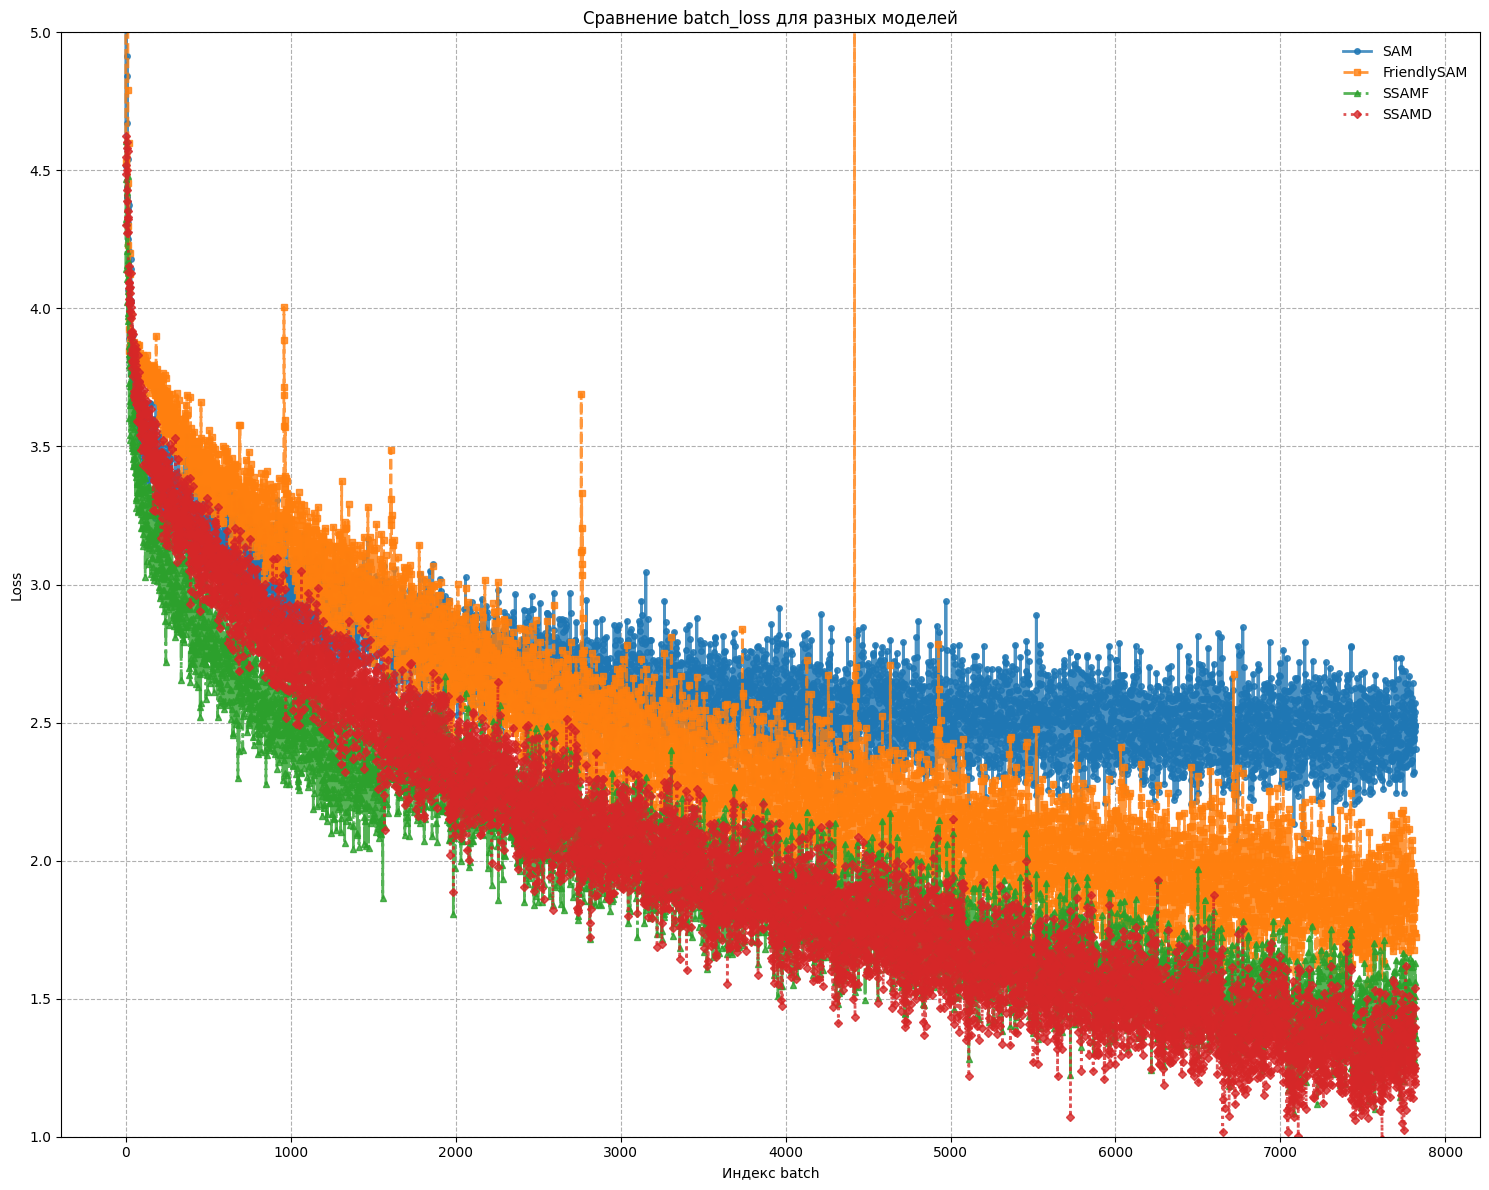

In [35]:
import matplotlib.pyplot as plt
from itertools import cycle

line_styles = cycle(['-', '--', '-.', ':'])
markers     = cycle(['o', 's', '^', 'D'])
colors      = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

plt.figure(figsize=(15,12))
for name, losses in metrics['batch_loss'].items():
    style  = next(line_styles)
    mark   = next(markers)
    color  = next(colors)
    plt.plot(
        losses,
        label=name,
        linestyle=style,
        marker=mark,
        markersize=4,
        linewidth=2,
        alpha=0.8,
        color=color
    )

plt.xlabel('Индекс batch')
plt.ylabel('Loss')
plt.title('Сравнение batch_loss для разных моделей')
plt.legend(loc='upper right', frameon=False)
plt.grid(True, linestyle='--', alpha=1)

plt.ylim(top=5.0)
plt.ylim(bottom=1.0)

plt.tight_layout()
plt.show()


---

In [33]:
!pip install loss_landscapes

import numpy as np
from loss_landscapes.metrics import Loss
from loss_landscapes import random_plane
import matplotlib.pyplot as plt

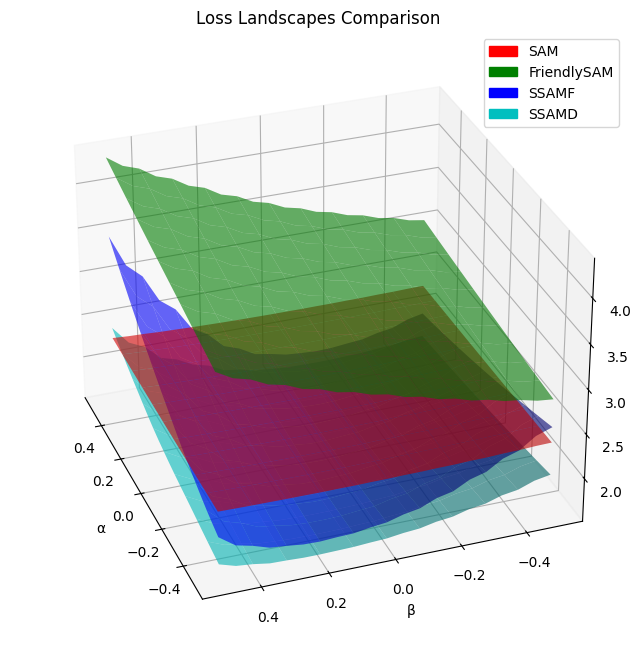

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

inputs, targets = next(iter(testloader))
metric_cpu = Loss(lambda out, targ: criterion(out, targ).mean(),
                  inputs.cpu(), targets.cpu())

fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111, projection='3d')

colors = ['r','g','b','c','m','y','k']
legend_patches = []

for (name, color) in zip(names, colors):
    model_cpu = models[name].cpu().eval()

    loss_matrix = random_plane(
        model_cpu,
        metric_cpu,
        40,
        21,
        normalization='filter',
        deepcopy_model=True
    )

    n = loss_matrix.shape[0]
    coords = np.linspace(-0.5, 0.5, n)
    X, Y   = np.meshgrid(coords, coords)

    ax.plot_surface(
        X, Y, loss_matrix,
        rstride=2, cstride=2,
        color=color,
        alpha=0.6,
        linewidth=0,
        antialiased=True
    )

    legend_patches.append(mpatches.Patch(color=color, label=name))

ax.view_init(elev=30, azim=160)
ax.set_title('Loss Landscapes Comparison')
ax.set_xlabel('α')
ax.set_ylabel('β')
ax.set_zlabel('Loss', labelpad=15)

ax.legend(handles=legend_patches, loc='upper right')

plt.show()
